In [2]:
# use pip to install pandas, matplotlib if needed
import os
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.utils import resample
from sklearn import set_config
from sksurv.nonparametric import kaplan_meier_estimator
set_config(display="text")  # displays text representation of estimators

os.chdir("..")
from scr.utils import *
from scr.runSurvModels import *

### Prepare Training Cohort--*This is done once and only; no longer need to rerun unless want to increase the total training cohort.*

In [2]:
# mxf = pd.read_csv(os.path.join("data","MSKpair_MXF_AEhead_maf_60000_Draw1.csv"),header=None)
# pmfh = pd.read_csv(os.path.join("data","MSKpair_PMFH_AEhead_maf_60000_Draw1.csv"),header=None)

# # rename columns
# mirna_names = pd.read_csv(os.path.join("data","MSKpair_miRNA_names.csv")).iloc[:,1].tolist()
# mxf.columns = pmfh.columns = mirna_names

# # sampling cohort
# mxf_sub = resample(mxf, n_samples=10000, replace=False)
# pmfh_sub = resample(pmfh, n_samples=10000, replace=False)

# mxf_sub.to_csv(os.path.join("data","MSKpair_MXF_10000.csv"), index=False)
# pmfh_sub.to_csv(os.path.join("data","MSKpair_PMFH_10000.csv"), index=False)

### *Test: Multiple Runs*

In [3]:
from abc import ABC, abstractmethod
class SurvivalModelPipeline(ABC):
    def __init__(self, X_train, y_train, X_test, y_test, dataName=None, hyperparameters=None):
        self.X_train=X_train
        self.y_train=y_train
        self.X_test=X_test  
        self.y_test=y_test
        self.dataName = dataName
        self.subset = [50,500,1000,2000,5000]
        self.runs =   [20, 20,  20,  10,   5]
        self.hyperparameters = hyperparameters
        self.model = None
        self.modelString = None
        
    @abstractmethod
    def build_model(self):
        pass
    
    def tune_hyperparameters(self, n_split, plotting_param=None):
        cv = KFold(n_splits=n_split, shuffle=True, random_state=42)
        model_cv = GridSearchCV(self.model,
            param_grid=self.hyperparameters,
            cv=cv,
            error_score=0.5,
            n_jobs=-1,
        ).fit(self.X_train, self.y_train)
        
        self.model = model_cv.best_estimator_
        
        if plotting_param is not None:
            cv_results = pd.DataFrame(model_cv.cv_results_)
            try:
                params = cv_results[f'param_{plotting_param}'].map(lambda x: x[0])
            except TypeError:
                params = cv_results[f'param_{plotting_param}']
            mean = cv_results.mean_test_score
            std = cv_results.std_test_score
            
            _, ax = plt.subplots(figsize=(6,4))
            ax.plot(params, mean)
            ax.fill_between(params, mean - std, mean + std, alpha=0.15)
            ax.set_xscale("log")
            ax.set_xlabel(plotting_param)
            ax.set_ylabel("concordance index")
            ax.axvline(model_cv.best_params_[plotting_param][0] 
                            if isinstance(model_cv.best_params_[plotting_param], list)
                            else model_cv.best_params_[plotting_param], 
                        c="C1")
            ax.grid(True)
        return model_cv
    
    
    def train(self, subset=None, runs=None):
        """
        Args:
            subset (list, optional): _description_. Defaults to None.
            save_model (bool, optional): _description_. Defaults to True.
        Returns:
            
        """
        subset = self.subset if subset is None else subset
        runs   = self.runs if runs is None else runs        
        # model_dict = {}
        n_train, model_time, model_train_scores, model_test_scores = [],[],[],[]
        
        for n, n_run in zip(subset, runs):
            
            run_time, run_train_scores, run_test_scores = [],[],[]
            for run in range(n_run):
                #=============== prepare data =================
                if n < self.X_train.shape[0]:
                    x_train,_, y_train,_ = train_test_split(
                        self.X_train, self.y_train,
                        train_size=n / self.X_train.shape[0], 
                        shuffle=True, random_state=run, 
                        stratify=[val[0] for val in self.y_train]
                    )
                else:
                    x_train = self.X_train
                    y_train = self.y_train
                    
                #================ Fit model ===================
                start = time.time() # Record iteration start time
                # Train the model with subset of training set
                model = self.model.fit(x_train, y_train)
                stop = time.time() # Record time when training finished
                duration = round(stop - start, 2)
                
                #=========== Get evaluation metrics ===========
                train_sc = model.score(x_train, y_train)
                test_sc = model.score(self.X_test, self.y_test)
                
                n_train.append(n)
                model_time.append(duration)
                model_train_scores.append(train_sc)
                model_test_scores.append(test_sc)
                
                run_train_scores.append(train_sc)
                run_test_scores.append(test_sc)
                run_time.append(duration)

            print(f"N={n} Training time ({np.mean(run_time)}s): Train C-Index: {round(np.mean(run_train_scores),3)} | Test C-index: {round(np.mean(run_test_scores),3)} (Mean)")                
                
        # ============== Save results ===============
        model_results = pd.DataFrame({
            'n train': n_train, 
            'train time':model_time,
            'train score':model_train_scores, 
            'test score':model_test_scores}
        )
        
        return model_results

    def write(self, model_results, output_dir=None, fileName='model.results.txt'):
            output_dir=os.path.join('models', self.dataName, self.modelString) if output_dir is None else output_dir
            os.makedirs(output_dir, exist_ok=True)
            write_file_path = os.path.join(output_dir, fileName)
            
            # save results as text file
            if 'txt' in write_file_path:
                model_results.to_csv(write_file_path, sep='\t')
            elif 'csv' in output_dir:
                model_results.to_csv(write_file_path, index=False)
            else:
                print('Please specify a file name with either a txt or csv extension.')  


class CoxPHElasticNetModel(SurvivalModelPipeline):
    def build_model(self, **kwargs):
        self.model = CoxnetSurvivalAnalysis(**kwargs)
        self.modelString = 'coxnet'
        
        if self.hyperparameters is None:
            self.hyperparameters = {
                'alphas': [ [2.0**i] for i in np.arange(-6, 3, 2)],
                'l1_ratio': np.linspace(0.2, 1, 5),
            }

class SVMSurvivalModel(SurvivalModelPipeline):
    def build_model(self, **kwargs):
        self.model = FastKernelSurvivalSVM(**kwargs)
        self.modelString = 'svm'

        if self.hyperparameters is None:
            self.hyperparameters = {
                'alpha': 2.0**np.arange(-10, 2, 2),
                'kernel': ['linear', 'polynomial', 'cosine','rbf'], #[‘additive_chi2’, ‘chi2’, ‘linear’, ‘poly’, ‘polynomial’, ‘rbf’, ‘laplacian’, ‘sigmoid’, ‘cosine’]
                'rank_ratio': np.linspace(0, 1, 6)
            }

class RandomSurvivalForestModel(SurvivalModelPipeline):
    def build_model(self, **kwargs):
        self.model = RandomSurvivalForest(**kwargs)
        self.modelString = 'rsf'
        
        if self.hyperparameters is None:
            self.hyperparameters = {
                'n_estimators': [100,200,500],
                'max_depth': [3, 5, 10],
                'min_samples_split': [5, 10, 15],
            }

In [6]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest",'20000']
DATANAME = 'linear-moderate'

train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

Train event rate: 0.7505
Test event rate:  0.7505


In [26]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [2.0**i] for i in np.arange(-6, 3, 3)],
    'l1_ratio': [0.2]
}
kwargs = {
    'alphas': [0.5],
    'l1_ratio': 0.2
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)

coxnet_results = coxnet.train(subset=subset, runs=runs, save_results=True, fileName='model.results.multiple.txt')

N=50 Training time (0.0s): Train C-Index: 0.872 | Test C-index: 0.74 (Mean)
N=500 Training time (0.008s): Train C-Index: 0.794 | Test C-index: 0.785 (Mean)
N=1000 Training time (0.01s): Train C-Index: 0.789 | Test C-index: 0.787 (Mean)
N=2000 Training time (0.024s): Train C-Index: 0.79 | Test C-index: 0.789 (Mean)
N=5000 Training time (0.064s): Train C-Index: 0.788 | Test C-index: 0.789 (Mean)


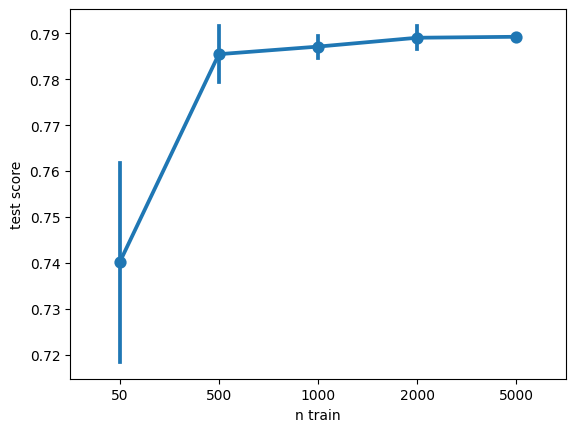

In [ ]:
p = sns.pointplot(data=coxnet_results, x='n train', y='test score', ci='sd', estimator='mean')
# # p.legend(title='g', bbox_to_anchor=(1.05, 1), loc='upper left')

# Deep Learning Method

When running different packages, different python environments might be needed. Therefore, we create virtual environments with varying python versions to avoid package version incompatibilities. The usual steps are as follows:


> venv/Scripts/activate

Or, if you are operating from a MacOS/Linux system:

> source venv/bin/activate

## DeepSurv
> git clone https://github.com/jaredleekatzman/DeepSurv.git \
> cd DeepSurv\
> pip install .

## DeepSurvK (Python v3.8+)
DeepSurvK is an adaptation of DeepSurv to deep NN training with Keras `Tensorflow` in later versions of python. It's also easier to install using the `pip` tool that comes with python installation. Here's how:

> pip install deepsurvk

## Cox-nnet

*NOTE: Cox-nnet requires python2.x which is currently deprecated. Due to dependency inavailability, we no longer consider including this method in the comparison.*

Using the bellow command lines to install the cox-nnet package (*Python version 2.7.* *)
> git clone https://github.com/lanagarmire/cox-nnet.git \
> cd cox-nnet \
> pip install . 

# Simulation Data: Virtual Rehybridization

In [2]:
surv_cols = ['t', 'delta']

In [3]:
# load simulated data
df_train_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_train_noBatch.csv")).iloc[:, 1:]
df_train_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_train_withBatch.csv")).iloc[:, 1:]
df_test_noBatch    = pd.read_csv(os.path.join("data","batch", "demo_sim_test_noBatch.csv")).iloc[:, 1:]

print("Event rate in the train data: %f" % (sum(df_train_noBatch['delta']) / df_train_noBatch.shape[0]))
print("Event rate in the test data: %f" % (sum(df_test_noBatch['delta']) / df_test_noBatch.shape[0])) 

Event rate in the train data: 0.760417
Event rate in the test data: 0.760417


## Scenario 1: No handling effect in training set (HE00)

In [13]:
# load data
train_df = df_train_noBatch
test_df  = df_test_noBatch
DATANAME = 'vh-no-batch'

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='t', status_col='delta')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='t', status_col='delta')

subset = [12, 24, 48, X_train.shape[0]]

### Baseline: CoxPH Elastic Net Regression

In [ ]:
# parameters for CoxPH elastic net model
kwargs = {'l1_ratio':1, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
print(coxnet.model)

coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet.write(coxnet_dict)
coxnet_results

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, 

CoxnetSurvivalAnalysis(alphas=[0.125], l1_ratio=0.4, max_iter=20000)
N=12 Training time (0.01s): Train C-Index: 1.0 | Test C-index: 0.863
N=24 Training time (0.02s): Train C-Index: 0.996 | Test C-index: 0.875
N=48 Training time (0.02s): Train C-Index: 0.986 | Test C-index: 0.911
N=96 Training time (0.02s): Train C-Index: 0.959 | Test C-index: 0.941


,n train,train time,train score,test score
0,12,0.01,1.000000,0.863219
1,24,0.02,0.995816,0.875060
2,48,0.02,0.986421,0.910826
3,96,0.02,0.959159,0.941034


### Support Vector Machine

In [ ]:
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
svm.build_model(**{'max_iter': 100})
svm_cv = svm.tune_hyperparameters(n_split=5)
svm_cv.best_params_
svm.build_model(**svm_cv.best_params_)
svm_result, svm_dict = svm.train(subset=subset)
svm.write(svm_result)

N=12 Training time (0.02s): Train C-Index: 0.967 | Test C-index: 0.785
N=24 Training time (0.04s): Train C-Index: 0.962 | Test C-index: 0.814
N=48 Training time (0.05s): Train C-Index: 0.932 | Test C-index: 0.854
N=96 Training time (0.19s): Train C-Index: 0.931 | Test C-index: 0.916


### Random Survival Forest

In [19]:
hyperparameters = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [5,15,25]
}
# parameters for fitting RSF models
kwargs = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_split':10,
    'min_samples_leaf':15,
    'n_jobs':-1
}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
rsf.build_model(**kwargs)
rsf_cv = rsf.tune_hyperparameters(n_split=5)
rsf_result, rsf_dict = rsf.train(subset=subset)
rsf.write(rsf_result)

N=12 Training time (0.92s): Train C-Index: 0.943 | Test C-index: 0.701
N=24 Training time (0.96s): Train C-Index: 0.946 | Test C-index: 0.855
N=48 Training time (0.9s): Train C-Index: 0.956 | Test C-index: 0.885
N=96 Training time (0.87s): Train C-Index: 0.948 | Test C-index: 0.922


In [20]:
rsf.model

RandomSurvivalForest(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                     n_estimators=500, n_jobs=-1)

## Scenario 2: Handling effect in training set (HE10)

In [21]:
train_df = df_train_withBatch.drop(columns='batch_id')
test_df = df_test_noBatch

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='t', status_col='delta')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='t', status_col='delta')
DATANAME = "vh-with-batch"

subset = [12, 24, 48, X_train.shape[0]]

### Baseline: Coxnet

In [27]:
# parameters for CoxPH elastic net model
kwargs = {'l1_ratio':1, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
print(coxnet.model)

coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet.write(coxnet_dict)

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, 

CoxnetSurvivalAnalysis(alphas=[0.5], l1_ratio=0.2, max_iter=20000)
N=12 Training time (0.01s): Train C-Index: 1.0 | Test C-index: 0.744
N=24 Training time (0.01s): Train C-Index: 0.958 | Test C-index: 0.746
N=48 Training time (0.01s): Train C-Index: 0.896 | Test C-index: 0.819
N=96 Training time (0.01s): Train C-Index: 0.813 | Test C-index: 0.897


### Support Vector Machine

In [28]:
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
svm.build_model(**{'max_iter': 100})
svm_cv = svm.tune_hyperparameters(n_split=5)
svm_cv.best_params_
svm.build_model(**svm_cv.best_params_)
svm_result, svm_dict = svm.train(subset=subset)
svm.write(svm_result)

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily achieved due to precision loss.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: ConvergenceWarning: Optimization did not converge: Warning: Desired error not necessarily 

N=12 Training time (0.01s): Train C-Index: 0.869 | Test C-index: 0.739
N=24 Training time (0.02s): Train C-Index: 0.908 | Test C-index: 0.748
N=48 Training time (0.05s): Train C-Index: 0.891 | Test C-index: 0.782
N=96 Training time (0.2s): Train C-Index: 0.914 | Test C-index: 0.891


### RSF

In [29]:
hyperparameters = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [3,10,20],
    'min_samples_leaf': [5,15,25]
}
# parameters for fitting RSF models
kwargs = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_split':10,
    'min_samples_leaf':15,
    'n_jobs':-1
}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
rsf.build_model(**kwargs)
rsf_cv = rsf.tune_hyperparameters(n_split=5)
print(rsf.model)
rsf_result, rsf_dict = rsf.train(subset=subset)
rsf.write(rsf_result)

RandomSurvivalForest(max_depth=5, min_samples_leaf=25, min_samples_split=3,
                     n_estimators=500, n_jobs=-1)
N=12 Training time (0.94s): Train C-Index: 0.5 | Test C-index: 0.5
N=24 Training time (0.92s): Train C-Index: 0.5 | Test C-index: 0.5
N=48 Training time (0.97s): Train C-Index: 0.5 | Test C-index: 0.5
N=96 Training time (1.0s): Train C-Index: 0.803 | Test C-index: 0.898


In [36]:
n=48
x_train,_, y_train,_ = train_test_split(
                    X_train, y_train,
                    train_size=n/X_train.shape[0], 
                    shuffle=True, random_state=42, stratify=[val[0] for val in y_train]
                )
y_train

array([( True, 15.42), ( True, 30.61), ( True,  6.87), (False, 37.51),
       (False, 47.67), ( True, 35.41), ( True, 13.18), ( True, 13.68),
       ( True, 11.7 ), ( True, 10.09), ( True, 17.62), (False, 52.87),
       ( True, 12.66), ( True, 12.66), ( True, 22.16), ( True, 18.18),
       ( True, 41.23), ( True, 36.  ), ( True, 13.35), ( True, 12.56),
       ( True, 16.5 ), ( True, 26.89), ( True,  8.81), (False, 54.77),
       ( True,  5.33), ( True, 13.71), ( True,  7.23), ( True, 24.85),
       ( True,  9.63), ( True, 25.35), (False, 42.61), ( True, 23.74),
       ( True, 12.13), (False, 49.05), (False, 36.49), ( True, 15.75),
       (False, 72.49), ( True, 13.28), ( True, 14.1 ), ( True, 21.11),
       ( True,  7.69), ( True, 18.05), (False, 71.84), ( True, 19.1 ),
       (False, 35.93), ( True, 15.98), (False,  0.26), ( True, 12.76)],
      dtype=[('Status', '?'), ('Survival_in_months', '<f8')])

# TCGA Real World Data (RWD)

## 1. TCGA-SKCM (minimal batch)

Number of events: 212
Number of censored cases: 292


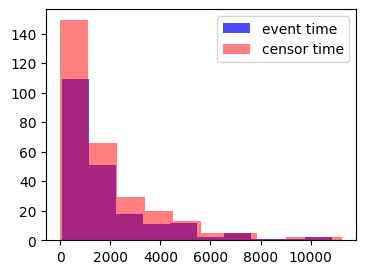

In [2]:
skcm_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-SKCM_miRNA_normalized.csv"), index_col=0).T
skcm_clin = pd.read_csv(os.path.join("data", "batch", "TCGA-SKCM_clinical_data.csv"))

skcm_mirna
skcm_clin = skcm_clin.set_index('submitter_id')
skcm_clin
skcm = pd.merge(skcm_mirna, skcm_clin, left_index=True, right_index=True)
skcm_df = skcm.loc[:, ['days_to_death', 
                       'days_to_last_follow_up'] +
                    [col for col in skcm.columns if 'hsa' in col]]

deathtt = skcm_df['days_to_death'][~np.isnan(skcm_df['days_to_death'])]
censortt = skcm_df['days_to_last_follow_up'][~np.isnan(skcm_df['days_to_last_follow_up'])]
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
fig, _ = plt.subplots(figsize=(4,3))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [3]:
# get censoring status and survival time
skcm_df['status'] = [int(i) for i in ~np.isnan(skcm_df['days_to_death'])]

skcm_df['time'] = skcm_df['days_to_death']
skcm_df['time'][np.isnan(skcm_df['time'])] = skcm_df['days_to_last_follow_up'][np.isnan(skcm_df['time'])]

skcm_df = skcm_df.drop(columns=['days_to_death',"days_to_last_follow_up"])
skcm_df = skcm_df.dropna()

skcm_df = skcm_df[skcm_df['time']>0].reset_index(drop=True)
print("Event rate in the TCGA-SKCM data: %f" % (sum(skcm_df['status']) / skcm_df.shape[0]))

Event rate in the TCGA-SKCM data: 0.487356


In [5]:
train_df, test_df = train_test_split(skcm_df, test_size=0.2, random_state=42, stratify=skcm_df['status'])

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='time', status_col='status')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='time', status_col='status')

# parameters for fitting Baseline models
subset = [train_df.shape[0]]
kwargs = {'l1_ratio':0.9, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName='tcga-skcm')
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

# coxnet.write(coxnet_dict)
coxnet_results

N=348 Training time (0.28s): Train C-Index: 0.978 | Test C-index: 0.591


,n train,train time,train score,test score
0,348,0.28,0.9778,0.590808


## 2. TCGA-LAML (minimal batch)

Dimension of dataset: (188, 1883)
Number of events: 112
Number of censored cases: 65


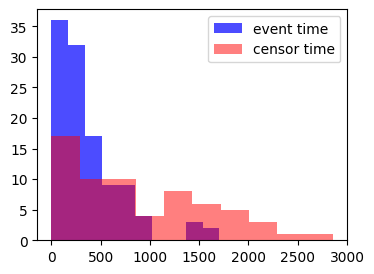

In [6]:
laml_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-LAML_miRNA_normalized.csv"), index_col=0).T
laml_clin = pd.read_csv(os.path.join("data", "batch", "TCGA-LAML_clinical_data.csv"))
laml_clin = laml_clin.set_index('submitter_id')

laml = pd.merge(laml_mirna, laml_clin, left_index=True, right_index=True)
laml_df = laml.loc[:, ['days_to_death', 
                       'days_to_last_follow_up'] +
                    [col for col in laml.columns if 'hsa' in col]]

deathtt = laml_df['days_to_death'][~np.isnan(laml_df['days_to_death'])]
censortt = laml_df['days_to_last_follow_up'][~np.isnan(laml_df['days_to_last_follow_up'])]

print(f'Dimension of dataset: {laml_df.shape}')
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
fig, _ = plt.subplots(figsize=(4,3))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [7]:
# get censoring status and survival time
laml_df['status'] = [int(i) for i in ~np.isnan(laml_df['days_to_death'])]

laml_df['time'] = laml_df['days_to_death']
laml_df['time'][np.isnan(laml_df['time'])] = laml_df['days_to_last_follow_up'][np.isnan(laml_df['time'])]


laml_df = laml_df.drop(columns=['days_to_death',"days_to_last_follow_up"])
laml_df = laml_df.dropna()

laml_df = laml_df[laml_df['time']>0].reset_index(drop=True)
print("Event rate in the TCGA-LAML data: %f" % (sum(laml_df['status']) / laml_df.shape[0]))

Event rate in the TCGA-LAML data: 0.609756


In [8]:
# laml.loc[laml['days_to_death']<=0, ['days_to_death','days_to_last_follow_up']]

In [10]:
train_df, test_df = train_test_split(laml_df, test_size=0.2, random_state=42, stratify=laml_df['status'])

X_train, y_train = dataframe_to_scikitsurv_ds(train_df, time_col='time', status_col='status')
X_test, y_test = dataframe_to_scikitsurv_ds(test_df, time_col='time', status_col='status')

# parameters for fitting Baseline models
subset = [train_df.shape[0]]
kwargs = {'l1_ratio':0.9, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName='tcga-laml')
coxnet.build_model(**kwargs)
coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)

# coxnet.write(coxnet_dict)
coxnet_results

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, consider decreasing alpha.
  estimator.fit(X_train, y_train, **fit_params)
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:888: UserWarning: all coefficients are zero, 

N=131 Training time (0.35s): Train C-Index: 1.0 | Test C-index: 0.634


,n train,train time,train score,test score
0,131,0.35,1.0,0.633929


# Simulation Data: Deep Generative miRNA data

In [4]:
subset = [50,500,1000,2000,5000]
runs = [20,20,10,10,10]

## 1. Linear: Moderate

In [5]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest", '20000']
DATANAME = 'linear-moderate'

train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

print(train_df.shape, test_df.shape)
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

(18000, 1035) (2000, 1035)
Train event rate: 0.7505
Test event rate:  0.7505


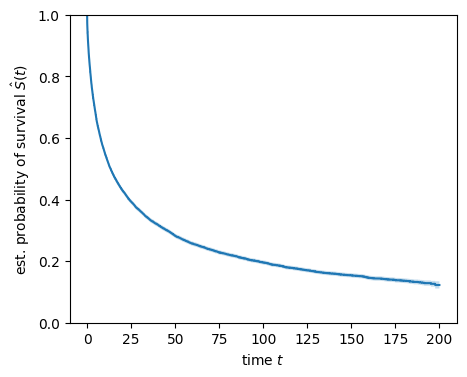

In [6]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    train_df["status"]==1, train_df["time"], conf_type="log-log"
)
_, ax = plt.subplots(figsize=(5,4))
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

### Baseline: Coxnet

In [7]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [2.0**i] for i in np.arange(-6, 3, 3)],
    'l1_ratio': [0.2]
}
kwargs = {
    'alphas': [0.5],
    'l1_ratio': 0.2
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)

coxnet_results = coxnet.train(subset=subset, runs=runs)
coxnet.write(coxnet_results, fileName="model.results.10runs.txt")
coxnet_results

# N=50 Training time (0.0s): Train C-Index: 0.833 | Test C-index: 0.715
# N=500 Training time (2.19s): Train C-Index: 0.741 | Test C-index: 0.734
# N=1000 Training time (0.01s): Train C-Index: 0.721 | Test C-index: 0.739
# N=2000 Training time (0.02s): Train C-Index: 0.724 | Test C-index: 0.738
# N=5000 Training time (0.07s): Train C-Index: 0.717 | Test C-index: 0.739
# N=8000 Training time (0.14s): Train C-Index: 0.718 | Test C-index: 0.739

N=50 Training time (0.0325s): Train C-Index: 0.872 | Test C-index: 0.741 (Mean)
N=500 Training time (0.08249999999999999s): Train C-Index: 0.794 | Test C-index: 0.787 (Mean)
N=1000 Training time (0.011s): Train C-Index: 0.789 | Test C-index: 0.788 (Mean)
N=2000 Training time (0.029000000000000005s): Train C-Index: 0.789 | Test C-index: 0.789 (Mean)
N=5000 Training time (0.06900000000000002s): Train C-Index: 0.788 | Test C-index: 0.789 (Mean)


,n train,train time,train score,test score
0,50,0.00,0.863216,0.744765
1,50,0.00,0.864594,0.765167
2,50,0.00,0.854474,0.716960
3,50,0.00,0.898826,0.718622
4,50,0.00,0.878140,0.755158
...,...,...,...,...
65,5000,0.07,0.787191,0.790141
66,5000,0.07,0.787690,0.790447
67,5000,0.07,0.785004,0.788589
68,5000,0.07,0.789958,0.789754


### Support Vector Machine

In [8]:
hyperparameters = {
    'alpha': [0.01,0.1,1],
    'kernel': ['linear', 'cosine','rbf'],
    'rank_ratio': np.linspace(0, 0.5, 1)
}
kwargs={
    'max_iter': 50,
    'alpha': 8,
    'kernel': 'cosine',
    'rank_ratio': 1
}
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
svm.build_model(**kwargs)
# svm_cv = svm.tune_hyperparameters(n_split=3)
# print(svm_cv.best_params_)
svm_result = svm.train(subset=[50,500,1000,2000], runs=[20,20,10,10])
svm.write(svm_result, fileName='model.results.10runs.txt')
svm_result

# {'alpha': 8.0, 'kernel': 'cosine', 'rank_ratio': 1.0}
# N=50 Training time (0.02s): Train C-Index: 0.652 | Test C-index: 0.588
# N=500 Training time (0.45s): Train C-Index: 0.588 | Test C-index: 0.579
# N=1000 Training time (1.81s): Train C-Index: 0.579 | Test C-index: 0.593
# N=2000 Training time (8.57s): Train C-Index: 0.612 | Test C-index: 0.609

N=50 Training time (0.126s): Train C-Index: 0.944 | Test C-index: 0.717 (Mean)
N=500 Training time (32.18249999999999s): Train C-Index: 0.917 | Test C-index: 0.773 (Mean)
N=1000 Training time (54.528s): Train C-Index: 0.894 | Test C-index: 0.786 (Mean)
N=2000 Training time (33.982s): Train C-Index: 0.844 | Test C-index: 0.813 (Mean)


,n train,train time,train score,test score
0,50,0.14,0.940850,0.716041
1,50,0.12,0.944835,0.757838
2,50,0.12,0.943953,0.710085
3,50,0.11,0.950316,0.694585
4,50,0.12,0.948837,0.739264
5,50,0.11,0.953555,0.707408
6,50,0.11,0.949767,0.710831
7,50,0.14,0.940952,0.720568
8,50,0.11,0.946550,0.695714
9,50,0.12,0.951763,0.715137


### RSF

In [ ]:
# parameters for fitting RSF models
kwargs = {'n_estimators':200, 
          'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':-1, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results = rsf.train(subset=[50,500,1000,2000], runs=[20,20,10,10])
rsf.write(rsf_results, fileName='model.results.10runs.txt')
rsf_results

# N=50 Training time (0.37049999999999994s): Train C-Index: 0.5 | Test C-index: 0.5 (Mean)
# N=500 Training time (1.748s): Train C-Index: 0.836 | Test C-index: 0.755 (Mean)
# N=1000 Training time (9.468s): Train C-Index: 0.84 | Test C-index: 0.772 (Mean)
# N=2000 Training time (48.576s): Train C-Index: 0.845 | Test C-index: 0.785 (Mean)

N=50 Training time (0.36550000000000005s): Train C-Index: 0.5 | Test C-index: 0.5 (Mean)
N=500 Training time (1.7655s): Train C-Index: 0.836 | Test C-index: 0.755 (Mean)


In [82]:
# idx = np.var(X_train, axis=0) > np.quantile(np.var(X_train, axis=0), 0.75)
# X_train_sub = X_train[:, idx]
# X_test_sub = X_test[:, idx]

# # parameters for fitting RSF models
# kwargs = {'n_estimators':100, 
#         'min_samples_split': 20,
#         'min_samples_leaf':20,
#         'n_jobs':-1, 
#         'random_state':42}
# rsf_sub = RandomSurvivalForestModel(X_train_sub, y_train, X_test_sub, y_test, dataName=DATANAME)
# rsf_sub.build_model(**kwargs)
# rsf_sub_result, _ = rsf_sub.train(subset=[8000])

N=8000 Training time (249.52s): Train C-Index: 0.79 | Test C-index: 0.729


## 2. Linear: Weak

(18000, 1036) (2000, 1036)
Train event rate: 0.7503333333333333
Test event rate:  0.7505
Survival time distribution:


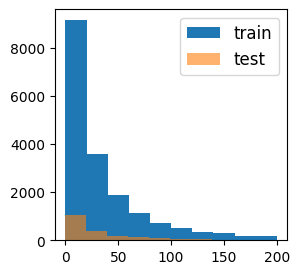

In [ ]:
# prepare data
folder = 'linear'
keywords = ['weak', "latest", '20000']
DATANAME = 'linear-weak'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(train_df.shape, test_df.shape)
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

### Baseline: Coxnet

In [11]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [0.5]],
    'l1_ratio': [0.2, 0.5, 0.8]
}
kwargs = {
    'alphas': [0.7],
    'l1_ratio': 0.8
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)
coxnet_results = coxnet.train(subset=subset, runs=runs)
coxnet.write(coxnet_results, fileName='model.results.10runs.txt')
coxnet_results

N=50 Training time (0.0055s): Train C-Index: 0.624 | Test C-index: 0.547 (Mean)
N=500 Training time (0.0s): Train C-Index: 0.521 | Test C-index: 0.514 (Mean)
N=1000 Training time (0.07s): Train C-Index: 0.501 | Test C-index: 0.498 (Mean)
N=2000 Training time (0.13499999999999998s): Train C-Index: 0.504 | Test C-index: 0.498 (Mean)
N=5000 Training time (0.05s): Train C-Index: 0.5 | Test C-index: 0.5 (Mean)


,n train,train time,train score,test score
0,50,0.00,0.640118,0.524217
1,50,0.00,0.657791,0.566965
2,50,0.00,0.587560,0.549931
3,50,0.00,0.650343,0.515538
4,50,0.00,0.500000,0.500000
...,...,...,...,...
65,5000,0.05,0.500000,0.500000
66,5000,0.05,0.500000,0.500000
67,5000,0.05,0.500000,0.500000
68,5000,0.05,0.500000,0.500000


### Support Vector Machine

In [12]:
hyperparameters = {
    'alpha': [0.01,0.1,1],
    'kernel': ['linear', 'cosine','rbf'],
    'rank_ratio': np.linspace(0, 0.5, 1)
}
kwargs={
    'max_iter': 50,
    'alpha': 8,
    'kernel': 'linear',
    'rank_ratio': 1
}
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
svm.build_model(**kwargs)
# svm_cv = svm.tune_hyperparameters(n_split=3)
# print(svm_cv.best_params_)
svm_result = svm.train(subset=subset, runs=runs)
svm.write(svm_result, fileName='model.results.10runs.txt')
svm_result

N=50 Training time (0.12599999999999997s): Train C-Index: 0.939 | Test C-index: 0.576 (Mean)
N=500 Training time (29.607999999999997s): Train C-Index: 0.888 | Test C-index: 0.647 (Mean)
N=1000 Training time (18.627000000000002s): Train C-Index: 0.814 | Test C-index: 0.675 (Mean)
N=2000 Training time (25.309s): Train C-Index: 0.763 | Test C-index: 0.698 (Mean)
N=5000 Training time (16.197000000000003s): Train C-Index: 0.724 | Test C-index: 0.701 (Mean)


,n train,train time,train score,test score
0,50,0.15,0.943953,0.591221
1,50,0.13,0.935897,0.589627
2,50,0.15,0.941627,0.586873
3,50,0.12,0.926543,0.591616
4,50,0.13,0.950429,0.579805
...,...,...,...,...
65,5000,12.73,0.722901,0.703992
66,5000,10.47,0.721380,0.698003
67,5000,6.90,0.706574,0.688544
68,5000,6.78,0.715265,0.693409


### RSF

In [4]:
# parameters for fitting RSF models
kwargs = {'n_estimators':200, 
          'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':-1, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results = rsf.train(subset=[50, 500, 1000, 2000], runs=[20,20,10,5])
rsf_results

N=50 Training time (0.36800000000000005s): Train C-Index: 0.5 | Test C-index: 0.5 (Mean)
N=500 Training time (2.024s): Train C-Index: 0.812 | Test C-index: 0.639 (Mean)
N=1000 Training time (10.475s): Train C-Index: 0.811 | Test C-index: 0.653 (Mean)
N=2000 Training time (49.818s): Train C-Index: 0.809 | Test C-index: 0.661 (Mean)


,n train,train time,train score,test score
0,50,0.36,0.500000,0.500000
1,50,0.33,0.500000,0.500000
2,50,0.36,0.500000,0.500000
3,50,0.55,0.500000,0.500000
4,50,0.34,0.500000,0.500000
5,50,0.34,0.500000,0.500000
6,50,0.35,0.500000,0.500000
7,50,0.36,0.500000,0.500000
8,50,0.37,0.500000,0.500000
9,50,0.35,0.500000,0.500000


In [ ]:
rsf.write(rsf_results, fileName='model.results.10runs.txt')
# rsf_results.to_csv(os.path.join("models",DATANAME, 'model.results.10runs.txt'))

## 3. Nonliear: Quadratic terms

(18000, 1036) (2000, 1036)
Train event rate: 0.7462222222222222
Test event rate:  0.746
Survival time distribution:


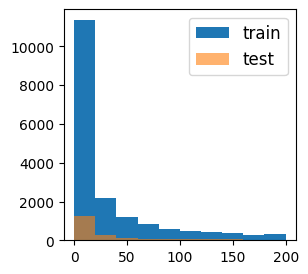

In [3]:
# prepare data
folder = 'nonlinear'
keywords = ['quadratic', "latest", '20000']
DATANAME = 'nl-quadratic'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
train_df.loc[train_df['time']==0,'time'] = 1e-4

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(train_df.shape, test_df.shape)
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

### Baseline: Coxnet

In [53]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [2.0**i] for i in np.arange(-6, 3, 3)],
    'l1_ratio': [0.2]
}
kwargs = {
    'alphas': [1],
    'l1_ratio': 0.2
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)
coxnet_results = coxnet.train(subset=subset, runs=runs, save_results=True, fileName='model.results.multiple.txt')

N=50 Training time (0.04s): Train C-Index: 0.724 | Test C-index: 0.535 (Mean)
N=500 Training time (0.006s): Train C-Index: 0.599 | Test C-index: 0.572 (Mean)
N=1000 Training time (0.164s): Train C-Index: 0.585 | Test C-index: 0.568 (Mean)
N=2000 Training time (0.692s): Train C-Index: 0.581 | Test C-index: 0.572 (Mean)
N=5000 Training time (0.05s): Train C-Index: 0.576 | Test C-index: 0.572 (Mean)


### Support Vector Machine

In [ ]:
hyperparameters = {
    'alpha': [0.01,0.1,1],
    'kernel': ['poly','rbf'],
    'rank_ratio': np.linspace(0, 0.5, 1)
}
kwargs={
    'max_iter': 50,
    'alpha': 8,
    'kernel': 'rbf',
    'rank_ratio': 1,
}
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
svm.build_model(**kwargs)
# svm_cv = svm.tune_hyperparameters(n_split=3)
# print(svm.model)
svm_result = svm.train(subset=[50,500,1000,2000], runs=[20,20,10,10])
svm.write(svm_result, fileName='model.results.10runs.txt')

N=50 Training time (0.055500000000000015s): Train C-Index: 1.0 | Test C-index: 0.596 (Mean)
N=500 Training time (3.9659999999999997s): Train C-Index: 0.999 | Test C-index: 0.692 (Mean)
N=1000 Training time (7.963999999999999s): Train C-Index: 0.995 | Test C-index: 0.721 (Mean)
N=2000 Training time (7.210000000000001s): Train C-Index: 0.939 | Test C-index: 0.756 (Mean)


,n train,train time,train score,test score
0,50,0.09,1.000000,0.610324
1,50,0.07,1.000000,0.576555
2,50,0.04,1.000000,0.593884
3,50,0.05,1.000000,0.584931
4,50,0.05,1.000000,0.606006
5,50,0.05,1.000000,0.617618
6,50,0.06,1.000000,0.621149
7,50,0.06,1.000000,0.600159
8,50,0.06,1.000000,0.559518
9,50,0.05,1.000000,0.584925


### RSF

In [ ]:
kwargs = {'n_estimators': 200, 
        'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':8, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results = rsf.train(subset=[50, 500, 1000, 2000], runs=[20,20,10,10])
rsf_results
rsf.write(rsf_results, fileName='model.results.10runs.txt')

N=50 Training time (0.26349999999999996s): Train C-Index: 0.5 | Test C-index: 0.5 (Mean)
N=500 Training time (1.4975s): Train C-Index: 0.806 | Test C-index: 0.694 (Mean)
N=1000 Training time (8.527s): Train C-Index: 0.819 | Test C-index: 0.722 (Mean)
N=2000 Training time (45.653000000000006s): Train C-Index: 0.831 | Test C-index: 0.742 (Mean)


,n train,train time,train score,test score
0,50,0.27,0.500000,0.500000
1,50,0.27,0.500000,0.500000
2,50,0.27,0.500000,0.500000
3,50,0.27,0.500000,0.500000
4,50,0.27,0.500000,0.500000
5,50,0.27,0.500000,0.500000
6,50,0.27,0.500000,0.500000
7,50,0.27,0.500000,0.500000
8,50,0.27,0.500000,0.500000
9,50,0.26,0.500000,0.500000


In [4]:
# train size 5000
kwargs = {'n_estimators': 200, 
        'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':8, 
        'random_state':42}
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results_5000 = rsf.train(subset=[5000], runs=[5])
rsf_results_5000
# rsf.write(rsf_results_5000, fileName='model.results.5000.5runs.txt')

: 

## 4. Nonliear: Quadratic Interaction

(18000, 1036) (2000, 1036)
Train event rate: 0.75
Test event rate:  0.75
Survival time distribution:


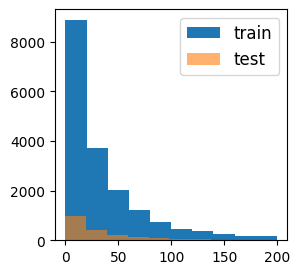

In [4]:
# prepare data
folder = 'nonlinear'
keywords = ['interaction', "latest", '20000']
DATANAME = 'nl-interaction'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(train_df.shape, test_df.shape)
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

### Baseline: Coxnet

In [57]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [2.0**i] for i in np.arange(-6, 3, 3)],
    'l1_ratio': [0.2]
}
kwargs = {
    'alphas': [0.5],
    'l1_ratio': 0.2
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)
coxnet_results = coxnet.train(subset=subset, runs=runs, save_results=True, fileName='model.results.multiple.txt')

N=50 Training time (0.0s): Train C-Index: 0.829 | Test C-index: 0.565 (Mean)
N=500 Training time (0.308s): Train C-Index: 0.643 | Test C-index: 0.603 (Mean)
N=1000 Training time (0.978s): Train C-Index: 0.642 | Test C-index: 0.608 (Mean)
N=2000 Training time (0.834s): Train C-Index: 0.632 | Test C-index: 0.609 (Mean)
N=5000 Training time (4.546s): Train C-Index: 0.627 | Test C-index: 0.613 (Mean)


### Support Vector Machine

In [5]:
hyperparameters = {
    'alpha': [0.01,0.1,1],
    'kernel': ['poly','rbf'],
    'rank_ratio': np.linspace(0, 0.5, 1)
}
kwargs={
    'max_iter': 50,
    'alpha': 8,
    'kernel': 'cosine',
    'rank_ratio': 1
}
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
svm.build_model(**kwargs)
# svm_cv = svm.tune_hyperparameters(n_split=3)
# print(svm.model)
svm_result = svm.train(subset=[50,500,1000,2000], runs=[20,20,10,10])
svm_result
# svm.write(svm_result, fileName='model.results.10runs.txt')

N=50 Training time (0.07350000000000002s): Train C-Index: 0.932 | Test C-index: 0.556 (Mean)
N=500 Training time (18.849000000000004s): Train C-Index: 0.885 | Test C-index: 0.586 (Mean)
N=1000 Training time (17.198s): Train C-Index: 0.802 | Test C-index: 0.607 (Mean)
N=2000 Training time (10.384s): Train C-Index: 0.72 | Test C-index: 0.626 (Mean)


,n train,train time,train score,test score
0,50,0.08,0.934394,0.557126
1,50,0.06,0.950787,0.546489
2,50,0.07,0.951662,0.570334
3,50,0.07,0.919529,0.572265
4,50,0.06,0.915104,0.560067
5,50,0.06,0.933816,0.489302
6,50,0.07,0.929791,0.551952
7,50,0.07,0.909360,0.550493
8,50,0.10,0.924731,0.577570
9,50,0.09,0.933393,0.587416


### RSF

In [ ]:
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results, rsf_dict = rsf.train(subset=[50, 500, 1000, 2000], runs=[20,20,10,10])
# rsf.write(rsf_results, fileName='models.results.10runs.txt')
rsf_results

N=50 Training time (0.94s): Train C-Index: 0.732 | Test C-index: 0.575
N=500 Training time (5.47s): Train C-Index: 0.828 | Test C-index: 0.623
N=1000 Training time (28.59s): Train C-Index: 0.818 | Test C-index: 0.638
N=2000 Training time (137.64s): Train C-Index: 0.822 | Test C-index: 0.644


In [17]:
idx = np.var(X_train, axis=0) > np.quantile(np.var(X_train, axis=0), 0.75)
X_train_sub = X_train[:, idx]
X_test_sub = X_test[:, idx]

# parameters for fitting RSF models
kwargs = {'n_estimators':100, 
        'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':-1, 
        'random_state':42}
rsf_sub = RandomSurvivalForestModel(X_train_sub, y_train, X_test_sub, y_test, dataName=DATANAME)
rsf_sub.build_model(**kwargs)
rsf_sub_result, _ = rsf_sub.train(subset=[8000])
rsf_sub_result

N=8000 Training time (299.33s): Train C-Index: 0.784 | Test C-index: 0.63


,n train,train time,train score,test score
0,8000,299.33,0.783792,0.630414


## 5. Nonlinear: Sine

(18000, 1036) (2000, 1036)
Train event rate: 0.7483333333333333
Test event rate:  0.7485
Survival time distribution:


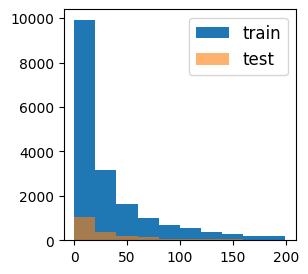

In [7]:
# prepare data
folder = 'nonlinear'
keywords = ['sine', "latest", '20000']
DATANAME = 'nl-sine'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.1)
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(train_df.shape, test_df.shape)
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

### Baseline: Coxnet

In [60]:
# parameters for CoxPH elastic net model
hyperparameters = {
    'alphas':[ [2.0**i] for i in np.arange(-5, 3, 2)],
    'l1_ratio': [0.2]
}
kwargs = {
    'alphas': [0.5],
    'l1_ratio': 0.2
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
coxnet.build_model(**kwargs)
# coxnet_cv = coxnet.tune_hyperparameters(n_split=5)
# print(coxnet.model)
coxnet_results = coxnet.train(subset=subset, runs=runs)
coxnet.write(coxnet_results, fileName='model.results.10runs.txt')
coxnet_results

N=50 Training time (0.0s): Train C-Index: 0.826 | Test C-index: 0.563 (Mean)
N=500 Training time (0.002s): Train C-Index: 0.649 | Test C-index: 0.625 (Mean)
N=1000 Training time (0.01s): Train C-Index: 0.628 | Test C-index: 0.626 (Mean)
N=2000 Training time (0.02s): Train C-Index: 0.623 | Test C-index: 0.628 (Mean)
N=5000 Training time (0.05s): Train C-Index: 0.618 | Test C-index: 0.629 (Mean)


### Support Vector Machine

In [ ]:
hyperparameters = {
    'alpha': [0.01,0.1,1],
    'kernel': ['poly','rbf'],
    'rank_ratio': np.linspace(0, 0.5, 1)
}
kwargs={
    'max_iter': 50,
    'alpha': 8,
    'kernel': 'cosine',
    'rank_ratio': 1
}
svm = SVMSurvivalModel(X_train, y_train, X_test, y_test, dataName=DATANAME, hyperparameters=hyperparameters)
svm.build_model(**kwargs)
# svm_cv = svm.tune_hyperparameters(n_split=3)
# print(svm.model)
svm_result = svm.train(subset=[50,500,1000,2000], runs=[20,20,10,10])
svm.write(svm_result, fileName='model.results.10runs.txt')
svm_result

N=50 Training time (0.07000000000000002s): Train C-Index: 0.942 | Test C-index: 0.552 (Mean)


### RSF

In [8]:
rsf = RandomSurvivalForestModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
rsf.build_model(**kwargs)
rsf_results, rsf_dict = rsf.train(subset=[50, 500, 1000, 2000, 5000], runs=[20,20,10,10,5])
# rsf.write(rsf_results, fileName='models.results.10runs.txt')
rsf_results

N=50 Training time (0.92s): Train C-Index: 0.746 | Test C-index: 0.567
N=500 Training time (5.74s): Train C-Index: 0.816 | Test C-index: 0.611
N=1000 Training time (28.27s): Train C-Index: 0.825 | Test C-index: 0.641
N=2000 Training time (128.46s): Train C-Index: 0.821 | Test C-index: 0.65
N=5000 Training time (979.55s): Train C-Index: 0.827 | Test C-index: 0.673


,n train,train time,train score,test score
0,50,0.92,0.746255,0.566608
1,500,5.74,0.816126,0.610657
2,1000,28.27,0.825152,0.640657
3,2000,128.46,0.821237,0.649756
4,5000,979.55,0.826720,0.672886


In [26]:
idx = np.var(X_train, axis=0) > np.quantile(np.var(X_train, axis=0), 0.75)
X_train_sub = X_train[:, idx]
X_test_sub = X_test[:, idx]

# parameters for fitting RSF models
kwargs = {'n_estimators':100, 
        'min_samples_split': 20,
        'min_samples_leaf':20,
        'n_jobs':-1, 
        'random_state':42}
rsf_sub = RandomSurvivalForestModel(X_train_sub, y_train, X_test_sub, y_test, dataName=DATANAME)
rsf_sub.build_model(**kwargs)
rsf_sub_result, _ = rsf_sub.train(subset=[8000])
rsf_sub_result

N=8000 Training time (297.49s): Train C-Index: 0.781 | Test C-index: 0.65


,n train,train time,train score,test score
0,8000,297.49,0.780865,0.649943


# Summarize Model Results

In [62]:
subset=[50, 500, 1000, 2000, 5000]
modelnames=['coxnet','svm','rsf','deepsurv-torch']

In [83]:
def load_simulate_results(dataFolderName, 
                        subset=[50, 500, 1000, 2000, 5000],
                        modelnames=['coxnet','svm','rsf','deepsurv-torch'],
                        fileName = 'model.results.multiple.txt',
                        how='outer'):
    
    results = pd.DataFrame({'n train': []})
    for mdl in modelnames:
        file_dir = os.path.join('models', dataFolderName, mdl, fileName)
        try:
            result_df = pd.read_table(file_dir, index_col=0)
        except:
            result_df = pd.read_table(os.path.join('models', dataFolderName, mdl, 'model.results.txt'), index_col=0)
        
        result_df.columns = ["_".join((col, mdl)) if col!='n train' else col for col in result_df.columns.tolist() ]
        results = results.merge(result_df, on='n train', how=how)

    return results

In [80]:
dataFolderName = 'linear-moderate'
subset=[50, 500, 1000, 2000, 5000]
modelnames=['coxnet','svm','rsf','deepsurv-torch']
fileName = 'model.results.multiple.txt'
how='inner'
    
results = pd.DataFrame({'n train': []})

In [81]:
for mdl in modelnames:
    file_dir = os.path.join('models', dataFolderName, mdl, fileName)
    try: 
        result_df = pd.read_table(file_dir, index_col=0)
    except:
        result_df = pd.read_table(os.path.join('models', dataFolderName, mdl, 'model.results.txt'), index_col=0)
    result_df.columns = ["_".join((col, mdl)) if col!='n train' else col for col in result_df.columns.tolist() ]
    results = results.merge(result_df, on='n train', how='outer')

In [82]:
results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_svm,train score_svm,test score_svm,train time_rsf,train score_rsf,test score_rsf,train time_deepsurv-torch,train score_deepsurv-torch,test score_deepsurv-torch
0,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.27,0.644118,0.539155
1,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.32,0.830721,0.640878
2,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.85,0.960692,0.676483
3,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.27,0.651297,0.556996
4,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.65,0.940594,0.698674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.56,0.842659,0.815028
622,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.96,0.845771,0.810730
623,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.73,0.843606,0.807787
624,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.59,0.837552,0.814116


### Batch effect on model performance

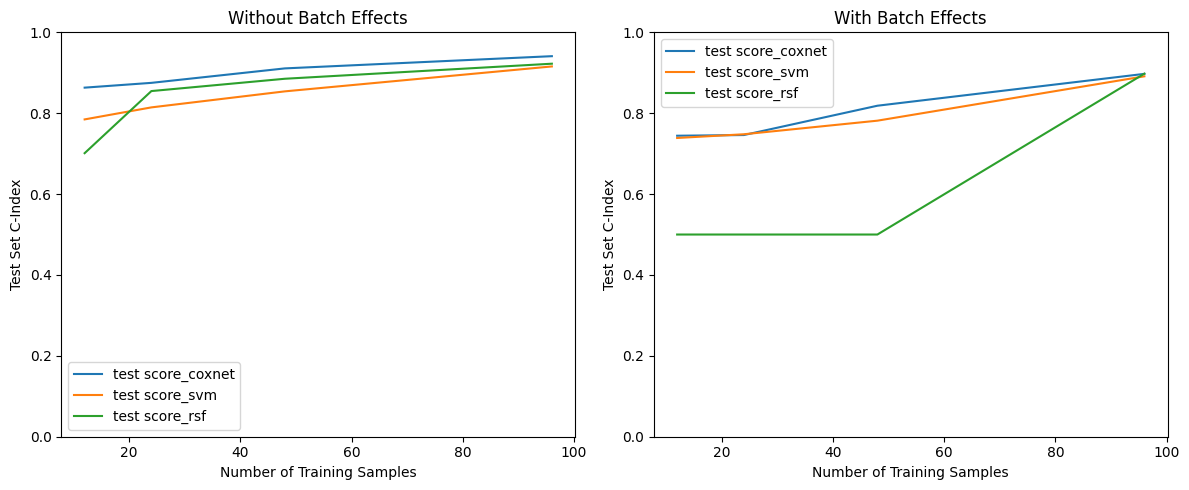

In [49]:
modelnames=['coxnet','svm','rsf']
vh_no_batch_results = load_simulate_results('vh-no-batch',
                      subset=[12,24,48,96],
                        modelnames=['coxnet','svm','rsf'])
    
vh_with_batch_results = load_simulate_results('vh-with-batch',
                      subset=[12,24,48,96],
                        modelnames=['coxnet','svm','rsf'])
    
vh_no_batch_results
# Plot train time comparison
_, ax = plt.subplots(1, 2, figsize=(12,5))
vh_no_batch_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax[0])
ax[0].set_title('Without Batch Effects')
ax[0].set_ylabel('Test Set C-Index')
ax[0].set_xlabel('Number of Training Samples')
ax[0].set_ylim(0,1)


vh_with_batch_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax[1])
ax[1].set_title('With Batch Effects')
ax[1].set_ylabel('Test Set C-Index')
ax[1].set_xlabel('Number of Training Samples')
ax[1].set_ylim(0,1)

plt.tight_layout()
plt.show()

### Linear/Nonlinear survival time simulation

In [ ]:
dt='linear-moderate'
mod_results=load_simulate_results(subset=subset, dataFolderName=dt)
mod_results

,n train,train time_coxnet,train score_coxnet,test score_coxnet,train time_svm,train score_svm,test score_svm,train time_rsf,train score_rsf,test score_rsf,train time_deepsurv-torch,train score_deepsurv-torch,test score_deepsurv-torch
0,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.27,0.644118,0.539155
1,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.32,0.830721,0.640878
2,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.85,0.960692,0.676483
3,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.27,0.651297,0.556996
4,50,0.00,0.863216,0.744765,0.10,1.000000,0.678085,1.08,0.739000,0.625000,0.65,0.940594,0.698674
...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.56,0.842659,0.815028
622,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.96,0.845771,0.810730
623,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.73,0.843606,0.807787
624,5000,0.07,0.786987,0.788543,29.11,0.868203,0.805401,881.86,0.826000,0.736000,4.59,0.837552,0.814116


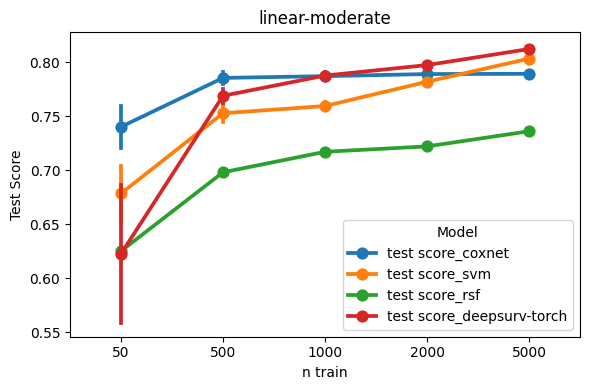

In [ ]:
dt='linear-moderate'
mod_results=load_simulate_results(subset=subset, dataFolderName=dt)

long_mod_results = mod_results.melt(
    id_vars=["n train"], 
    value_vars=["test score_coxnet", "test score_svm", "test score_rsf", "test score_deepsurv-torch"],
    var_name="Model", 
    value_name="Test Score"
)
long_mod_results = long_mod_results[long_mod_results['n train']!=8000]

fig, ax = plt.subplots( figsize=(6, 4))
# # Plot train time comparison
# mod_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax)
# ax.set_title(f'Model Performance Comparison: {dt}')
# ax.set_ylabel('Test Set C-Index')
# ax.set_xlabel('Number of Training Samples')
# ax.set_ylim(0,1)

p1 = sns.pointplot(data=long_mod_results, x='n train', y='Test Score', hue='Model', ci='sd', estimator='mean')
plt.title(dt)
plt.tight_layout()

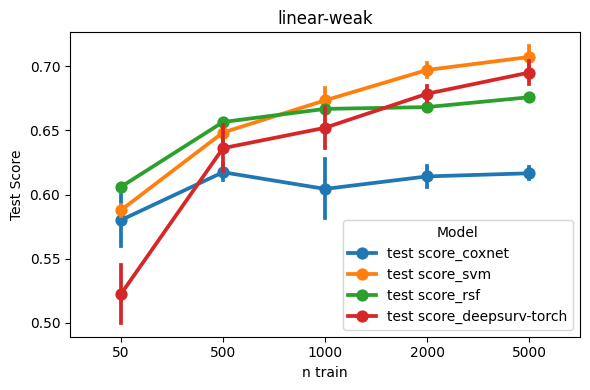

In [103]:
dt='linear-weak'
weak_results=load_simulate_results(subset=subset,dataFolderName=dt)
long_weak_results = weak_results.melt(
    id_vars=["n train"], 
    value_vars=["test score_coxnet", "test score_svm", "test score_rsf", "test score_deepsurv-torch"],
    var_name="Model", 
    value_name="Test Score"
)
long_weak_results = long_weak_results[long_weak_results['n train']!=8000]

fig, ax = plt.subplots( figsize=(6,4))
p2 = sns.pointplot(data=long_weak_results, x='n train', y='Test Score', hue='Model', ci='sd', estimator='mean')

# # Plot train time comparison
# weak_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax)
# ax.set_title(f'Model Performance Comparison: {dt}')
# ax.set_ylabel('Test Set C-Index')
# ax.set_xlabel('Number of Training Samples')
# ax.set_ylim(0,1)
plt.title(dt)
plt.tight_layout()

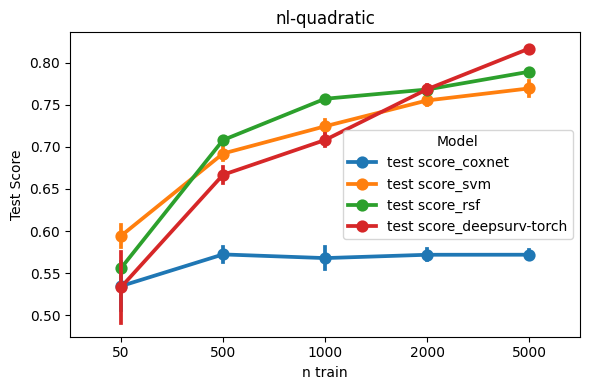

In [102]:
dt='nl-quadratic'
nl_quadratic_results = load_simulate_results(subset=subset,dataFolderName=dt)

fig, ax = plt.subplots( figsize=(6,4))
long_quadratic_results = nl_quadratic_results.melt(
    id_vars=["n train"], 
    value_vars=["test score_coxnet", "test score_svm", "test score_rsf", "test score_deepsurv-torch"],
    var_name="Model", 
    value_name="Test Score"
)
long_quadratic_results = long_quadratic_results[long_quadratic_results['n train']!=8000]
p3 = sns.pointplot(data=long_quadratic_results, x='n train', y='Test Score', hue='Model', ci='sd', estimator='mean')
plt.title(dt)
# # Plot train time comparison
# nl_quadratic_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax)
# ax.set_title(f'Model Performance Comparison: {dt}')
# ax.set_ylabel('Test Set C-Index')
# ax.set_xlabel('Number of Training Samples')
# ax.set_ylim(0,1)

plt.tight_layout()

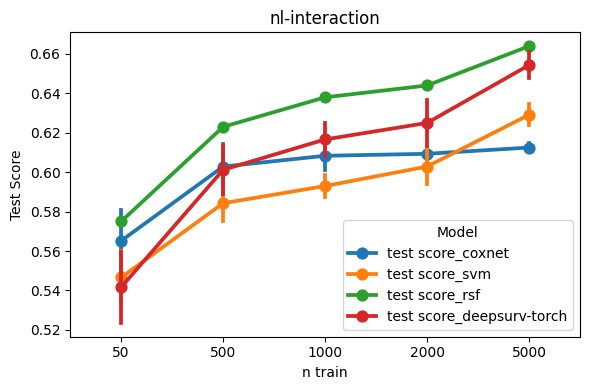

In [105]:
dt='nl-interaction'
nl_interact_results = load_simulate_results(subset=subset, dataFolderName=dt)

fig, ax = plt.subplots( figsize=(6,4))
long_interact_results = nl_interact_results.melt(
    id_vars=["n train"], 
    value_vars=["test score_coxnet", "test score_svm", "test score_rsf", "test score_deepsurv-torch"],
    var_name="Model", 
    value_name="Test Score"
)
long_interact_results = long_interact_results[long_interact_results['n train']!=8000]
p4 = sns.pointplot(data=long_interact_results, x='n train', y='Test Score', hue='Model', ci='sd', estimator='mean')

# # Plot train time comparison
# nl_interact_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax)
# ax.set_title(f'Model Performance Comparison: {dt}')
# ax.set_ylabel('Test Set C-Index')
# ax.set_xlabel('Number of Training Samples')
# ax.set_ylim(0,1)
plt.title(dt)
plt.tight_layout()

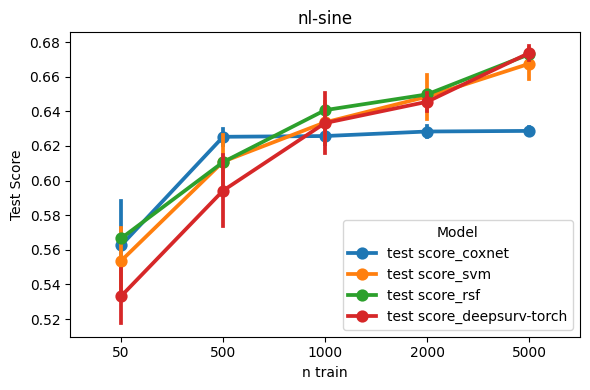

In [106]:
dt='nl-sine'
nl_sine_results = load_simulate_results(subset=subset,dataFolderName=dt)

fig, ax = plt.subplots( figsize=(6,4))
long_sine_results = nl_sine_results.melt(
    id_vars=["n train"], 
    value_vars=["test score_coxnet", "test score_svm", "test score_rsf", "test score_deepsurv-torch"],
    var_name="Model", 
    value_name="Test Score"
)
long_sine_results = long_sine_results[long_sine_results['n train']!=8000]
p5 = sns.pointplot(data=long_sine_results, x='n train', y='Test Score', hue='Model', ci='sd', estimator='mean')

# # Plot train time comparison
# nl_sine_results.plot(x='n train', y=['test score_'+name for name in modelnames], kind='line', ax=ax)
# ax.set_title(f'Model Performance Comparison: {dt}')
# ax.set_ylabel('Test Set C-Index')
# ax.set_xlabel('Number of Training Samples')
# ax.set_ylim(0,1)
plt.title(dt)
plt.tight_layout()

### DeepSurv Results

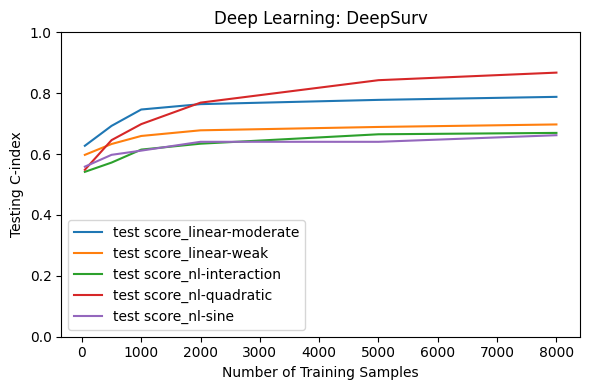

In [73]:
datanames = ['linear-moderate','linear-weak','nl-interaction','nl-quadratic','nl-sine']

deepsurv_results = pd.DataFrame({'n train': subset})
for name in datanames:
    file_dir = os.path.join('models', name ,'deepsurv-torch', 'model.results.txt')
    try:
        result_df = pd.read_table(file_dir, index_col=0)
    except:
        continue
    result_df.columns = ["_".join((col, name)) if col!='n train' else col for col in result_df.columns.tolist() ]
    deepsurv_results = deepsurv_results.merge(result_df, on='n train', how='outer')# right_on=result_df.columns[0])


# Plotting
fig, ax = plt.subplots( figsize=(6, 4))

# Plot train time comparison
deepsurv_results.plot(x='n train', y=['test score_'+name for name in datanames], kind='line', ax=ax)
ax.set_title('Deep Learning: DeepSurv')
ax.set_ylabel('Testing C-index')
ax.set_xlabel('Number of Training Samples')
ax.set_ylim(0,1)
plt.tight_layout()
plt.show()

### Baseline: CoxElasticNet

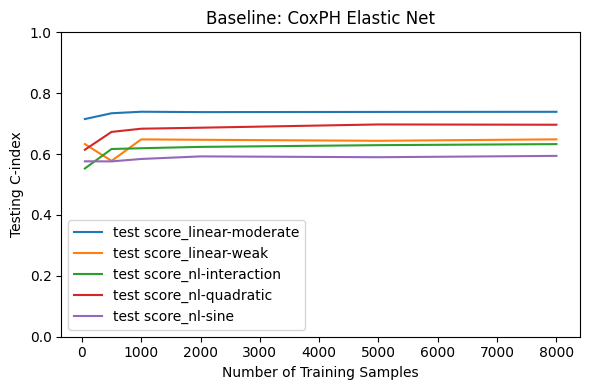

In [72]:
datanames = ['linear-moderate','linear-weak','nl-interaction','nl-quadratic','nl-sine']

cox_results = pd.DataFrame({'n train': subset})
for name in datanames:
    file_dir = os.path.join('models', name ,'coxnet', 'model.results.txt')
    try:
        result_df = pd.read_table(file_dir, index_col=0)
    except:
        continue
    result_df.columns = ["_".join((col, name)) if col!='n train' else col for col in result_df.columns.tolist() ]
    cox_results = cox_results.merge(result_df, on='n train', how='outer')# right_on=result_df.columns[0])

# Plotting
fig, ax = plt.subplots( figsize=(6, 4))

# Plot train time comparison
cox_results.plot(x='n train', y=['test score_'+name for name in datanames], kind='line', ax=ax)
ax.set_title('Baseline: CoxPH Elastic Net')
ax.set_ylabel('Testing C-index')
ax.set_xlabel('Number of Training Samples')
ax.set_ylim(0,1)
plt.tight_layout()
plt.show()

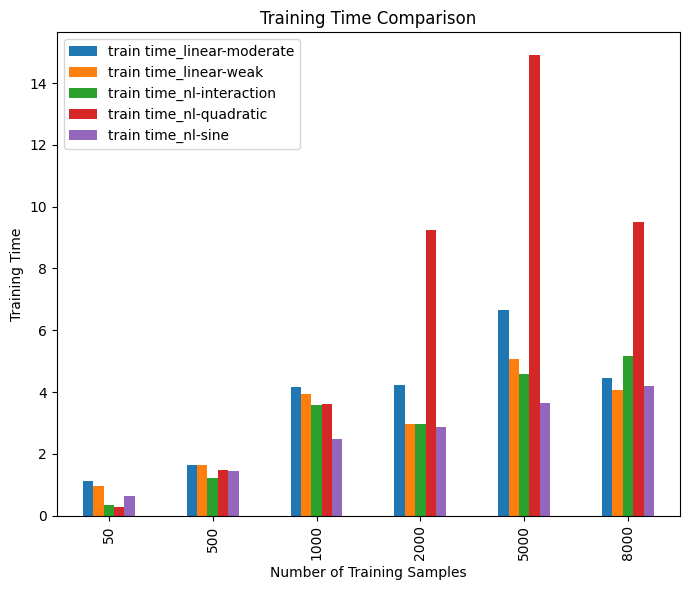

In [ ]:
deepsurv_results

## Gradient Boosting

In [8]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

In [9]:
est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.1, subsample=0.5, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

NameError: name 'EarlyStoppingMonitor' is not defined

In [16]:
gb_kwargs = {
    'n_estimators':500, 
    # 'n_jobs':-1, 
    'random_state':42
}
gb_hyperparameters = {
    'learning_rate': [0.1, 0.9],
    'max_depth': [1, 5, 10]
}

gb =  GradientBoostingSurvivalModel(X_train[:500], y_train[:500], X_test, y_test,
                                    hyperparameters=gb_hyperparameters)
gb.build_model(**gb_kwargs)
gb_cv = gb.tune_hyperparameters(n_split=5)
pd.DataFrame(gb_cv.cv_results_)

/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))
/home/nfs/dengy/mind-crc-env/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:83: RuntimeWarning: overflow encountered in exp
  self.baseline_survival_ = StepFunction(uniq_times, np.exp(-y))


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,78.987563,0.940394,0.018028,0.028702,0.1,1,"{'learning_rate': 0.1, 'max_depth': 1}",0.830909,0.816364,0.804242,0.841818,0.822626,0.823192,0.012748,1
1,246.343846,4.950607,0.005623,0.000440,0.1,5,"{'learning_rate': 0.1, 'max_depth': 5}",0.810505,0.809899,0.789697,0.796768,0.790707,0.799515,0.009057,4
2,309.232191,4.486070,0.009736,0.000189,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",0.748081,0.759192,0.746263,0.718384,0.754747,0.745333,0.014250,6
3,78.518984,1.109372,0.003462,0.000050,0.9,1,"{'learning_rate': 0.9, 'max_depth': 1}",0.811111,0.804040,0.812121,0.808485,0.807273,0.808606,0.002873,3
4,244.037484,6.315745,0.005808,0.000743,0.9,5,"{'learning_rate': 0.9, 'max_depth': 5}",0.827879,0.820202,0.809091,0.812121,0.806667,0.815192,0.007815,2
5,336.418411,25.017336,0.010486,0.000395,0.9,10,"{'learning_rate': 0.9, 'max_depth': 10}",0.767273,0.782828,0.763434,0.729495,0.754343,0.759475,0.017590,5


In [18]:
# parameters for fitting RSF models
kwargs = {'n_estimators':500, 
        'learning_rate':0.1,
        'max_depth':1,
        # 'n_jobs':-1, 
        'random_state':42}
gb = GradientBoostingSurvivalModel(X_train, y_train, X_test, y_test)
gb.build_model(**kwargs)
gb_results, gb_dict = gb.train(subset=[50,200,500,1000,2000,5000,8000])
gb.write(gb_dict)

# N=50 Training time (2.15s): Train C-Index: 0.996 | Test C-index: 0.685
# N=200 Training time (9.56s): Train C-Index: 0.944 | Test C-index: 0.785
# N=500 Training time (26.79s): Train C-Index: 0.91 | Test C-index: 0.808
# N=1000 Training time (60.01s): Train C-Index: 0.887 | Test C-index: 0.827
# N=2000 Training time (141.16s): Train C-Index: 0.873 | Test C-index: 0.837
# N=5000 Training time (488.76s): Train C-Index: 0.865 | Test C-index: 0.844

N=50 Training time (2.15s): Train C-Index: 0.996 | Test C-index: 0.685
N=200 Training time (9.56s): Train C-Index: 0.944 | Test C-index: 0.785
N=500 Training time (26.79s): Train C-Index: 0.91 | Test C-index: 0.808
N=1000 Training time (60.01s): Train C-Index: 0.887 | Test C-index: 0.827
N=2000 Training time (141.16s): Train C-Index: 0.873 | Test C-index: 0.837
N=5000 Training time (488.76s): Train C-Index: 0.865 | Test C-index: 0.844


In [17]:
%%time
random_state = 42
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
gb_dict, gb_train_scores, gb_test_scores = {},{},{}
for n in subset:
    start = time.time()
    gb = GradientBoostingSurvivalAnalysis(
        n_estimators=500, learning_rate=0.1, max_depth=1, random_state=0
        ).fit(X_train[:n], y_train[:n])
    gb_dict[str(n)] = gb
    stop = time.time()
    duration = round(stop-start, 3)
    
    train_score = gb.score(X_train[:n], y_train[:n])
    gb_train_scores[str(n)] = train_score
    test_score = gb.score(X_test, y_test)
    gb_test_scores[str(n)] = test_score
        
    print(
        f'N={n} Training Time {duration}s:\tTrain C-Index: {train_score} | Test C-Index: {test_score}'
    )

Train C-Index: 0.9918367346938776	| Test C-Index: 0.7448410690579366
Train C-Index: 0.9416264090177133	| Test C-Index: 0.7726718933947849
Train C-Index: 0.8974929690638811	| Test C-Index: 0.789535355559452
Train C-Index: 0.8696315018755892	| Test C-Index: 0.7998797685544673
Train C-Index: 0.8456953526199313	| Test C-Index: 0.8047316083460662
Train C-Index: 0.8256932671453335	| Test C-Index: 0.807749918593292


# Baseline: CoxPH model

### Hyperparameter Search

/tmp/ipykernel_377934/3934129116.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)


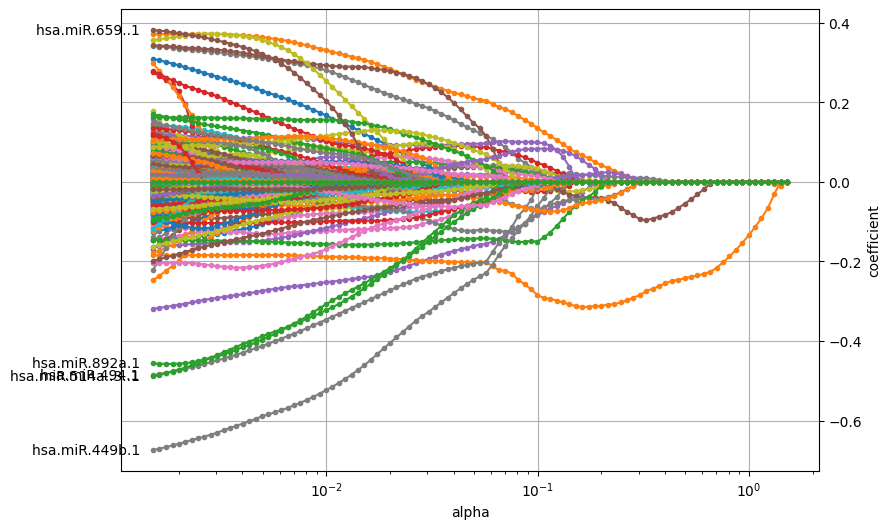

In [70]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)

coefficients = pd.DataFrame(coxnet.coef_, index=train_df.columns[:-2], columns=np.round(coxnet.alphas_, 5))
plot_coefficients(coefficients, n_highlight=5)

In [ ]:
alphas =  [0.1, 10] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
    'l1_ratio': [0.1, 0.9]
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet.build_model()
cv_results = coxnet.tune_hyperparameters(n_split=5, plotting_param='alphas')
# cv_results = pd.DataFrame(coxnet.cv_results_)
cv_results

In [13]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alphas,param_l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,46.204700,1.347625,0.055914,0.001843,[0.001],0.1,"{'alphas': [0.001], 'l1_ratio': 0.1}",0.911458,0.905810,0.908276,0.910700,0.908393,0.908927,0.001999,4
1,42.287379,2.126294,0.056750,0.007874,[0.001],0.9,"{'alphas': [0.001], 'l1_ratio': 0.9}",0.915196,0.909837,0.912978,0.914337,0.911887,0.912847,0.001883,2
2,34.823239,2.155184,0.093512,0.008081,[0.01],0.1,"{'alphas': [0.01], 'l1_ratio': 0.1}",0.913515,0.907758,0.911669,0.914191,0.911716,0.911770,0.002237,3
3,29.688668,1.168285,0.124735,0.025512,[0.01],0.9,"{'alphas': [0.01], 'l1_ratio': 0.9}",0.918818,0.913556,0.917085,0.919981,0.916771,0.917242,0.002183,1
4,16.543225,2.392059,0.178689,0.029070,[0.1],0.1,"{'alphas': [0.1], 'l1_ratio': 0.1}",0.901618,0.895208,0.900865,0.904381,0.900726,0.900560,0.002983,5
5,1.755442,0.192350,0.242111,0.042911,[0.1],0.9,"{'alphas': [0.1], 'l1_ratio': 0.9}",0.866313,0.859564,0.870020,0.872047,0.861307,0.865850,0.004820,6


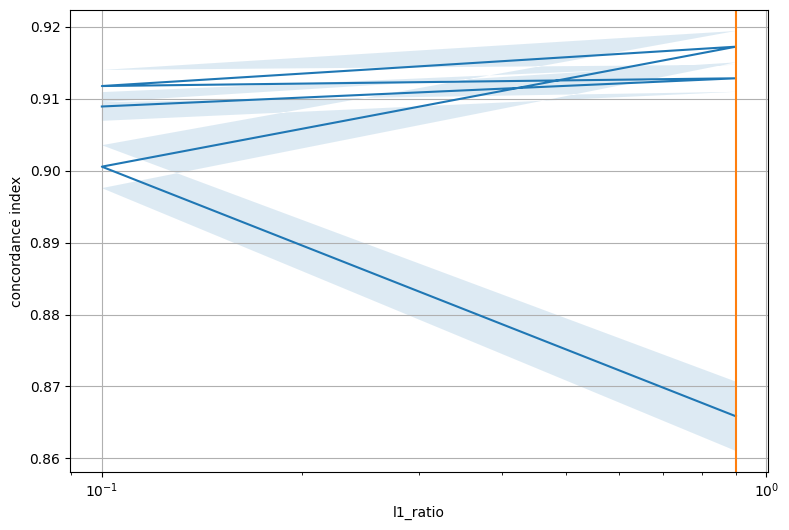

In [37]:
param = 'l1_ratio'
try:
    params = cv_results[f'param_{param}'].map(lambda x: x[0])
except TypeError:
    params = cv_results[f'param_{param}']
mean = cv_results.mean_test_score
std = cv_results.std_test_score


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(params, mean)
ax.fill_between(params, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_xlabel(param)
ax.set_ylabel("concordance index")
ax.axvline(coxnet_cv.best_params_[param][0] 
            if isinstance(coxnet_cv.best_params_[param], list)
            else coxnet_cv.best_params_[param], 
        c="C1")
ax.grid(True)

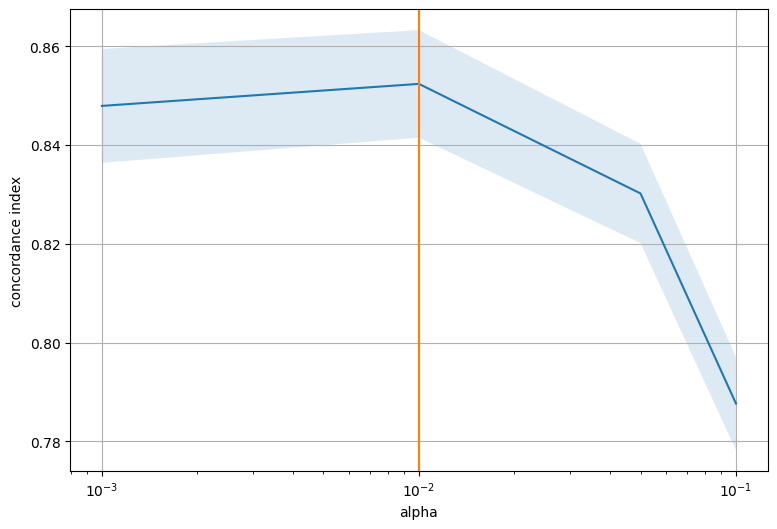

In [50]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(coxnet_cv.best_params_["alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [36]:
coxnet_cv.best_estimator_

CoxnetSurvivalAnalysis(alphas=[0.01], l1_ratio=0.9)

## Fitting model with best parameter

In [ ]:
random_state = 42
subset = [50, 500, 1000, 2000, 5000, 8000]


N=50 Training time (0.19s):	Train C-Index: 1.0 | Test C-index: 0.647
N=200 Training time (0.28s):	Train C-Index: 0.941 | Test C-index: 0.75
N=500 Training time (0.3s):	Train C-Index: 0.873 | Test C-index: 0.827
N=1000 Training time (0.68s):	Train C-Index: 0.864 | Test C-index: 0.841
N=2000 Training time (0.94s):	Train C-Index: 0.868 | Test C-index: 0.85
N=5000 Training time (2.04s):	Train C-Index: 0.856 | Test C-index: 0.853
N=8000 Training time (2.64s):	Train C-Index: 0.853 | Test C-index: 0.854
CPU times: user 8.2 s, sys: 55.8 ms, total: 8.26 s
Wall time: 8.21 s


In [39]:
# coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[1e-2], max_iter=10000)
# coxnet.fit(X_train, y_train)

In [14]:
coxnet.score(X_train, y_train)

0.8531652706588324

In [15]:
coxnet.score(X_test, y_test)

0.8536128064032016

Number of non-zero coefficients: 73


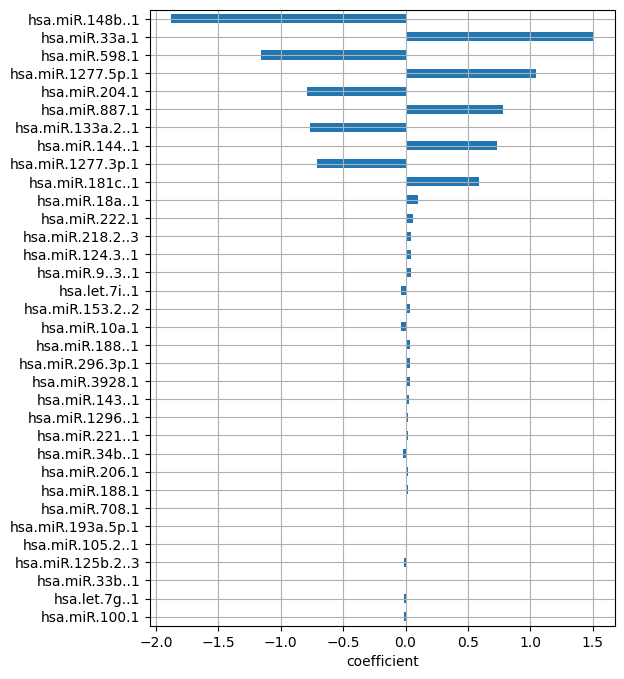

In [43]:

coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet.coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 1e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

## Load Data

### Linear: Moderate

In [3]:
# prepare data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
DATANAME = 'linear-moderate'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

Train event rate: 0.75075
Test event rate:  0.751


In [ ]:
# parameters for fitting GB models
subset=[
        50,500,1000,2000,5000,8000
]
kwargs = {
    'l1_ratio':0.9, 
    'alphas':[1e-1],
    'max_iter':20000
    }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results

N=50 Training time (0.0s): Train C-Index: 0.872 | Test C-index: 0.702


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (0.42s): Train C-Index: 0.731 | Test C-index: 0.731


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (0.63s): Train C-Index: 0.734 | Test C-index: 0.748
N=2000 Training time (0.03s): Train C-Index: 0.73 | Test C-index: 0.743


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=5000 Training time (6.34s): Train C-Index: 0.737 | Test C-index: 0.757
N=8000 Training time (0.16s): Train C-Index: 0.731 | Test C-index: 0.751


,n train,train time,train score,test score
0,50,0.00,0.871979,0.702455
1,500,0.42,0.730519,0.731492
2,1000,0.63,0.734483,0.747834
3,2000,0.03,0.730220,0.743442
4,5000,6.34,0.737380,0.757127
5,8000,0.16,0.731466,0.750603


In [8]:
coxnet.write(coxnet_results)

### Linear: Weak

Train event rate: 0.75025
Test event rate:  0.7505
Survival time distribution:


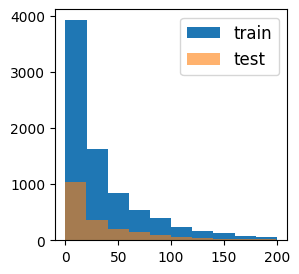

In [10]:
# prepare data
folder = 'linear'
keywords = ['weak', "latest", 'RW']
DATANAME = 'linear-weak'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [ ]:
alphas =  [0.01, 0.1, 1] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet.build_model()
cv_results = coxnet.tune_hyperparameters(n_split=5, plotting_param='alphas')
# cv_results = pd.DataFrame(coxnet.cv_results_)
cv_results

In [21]:
kwargs = {
    'l1_ratio': 0.9, 
    'alphas':[0.2],
    'max_iter': 100000
    }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results

N=50 Training time (0.0s): Train C-Index: 0.757 | Test C-index: 0.634


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (0.54s): Train C-Index: 0.585 | Test C-index: 0.586


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (1.65s): Train C-Index: 0.667 | Test C-index: 0.652
N=2000 Training time (0.02s): Train C-Index: 0.669 | Test C-index: 0.651
N=5000 Training time (0.06s): Train C-Index: 0.656 | Test C-index: 0.65
N=8000 Training time (0.12s): Train C-Index: 0.656 | Test C-index: 0.653


,n train,train time,train score,test score
0,50,0.00,0.756757,0.633786
1,500,0.54,0.585293,0.586348
2,1000,1.65,0.666956,0.652195
3,2000,0.02,0.668686,0.651006
4,5000,0.06,0.655616,0.650452
5,8000,0.12,0.655968,0.653250


In [24]:
coxnet.write(coxnet_results)

### Nonliear: Quadratic terms

Train event rate: 0.747875
Test event rate:  0.748
Survival time distribution:


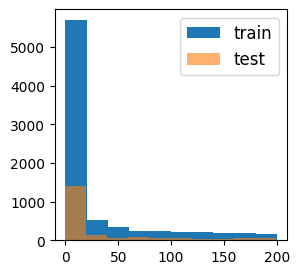

In [30]:
# prepare data
folder = 'nonlinear'
keywords = ['quadratic', "latest", 'RW']
DATANAME = 'nl-quadratic'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [28]:
kwargs = {
    'l1_ratio': 0.9, 
    'alphas':[1e-1],
    'max_iter': 100000
    }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results

/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=100000).
  model = self.model.fit(x_train, y_train)


N=50 Training time (0.57s): Train C-Index: 0.899 | Test C-index: 0.599
N=500 Training time (0.0s): Train C-Index: 0.682 | Test C-index: 0.629
N=1000 Training time (0.01s): Train C-Index: 0.658 | Test C-index: 0.642
N=2000 Training time (0.02s): Train C-Index: 0.633 | Test C-index: 0.621
N=5000 Training time (0.06s): Train C-Index: 0.629 | Test C-index: 0.63
N=8000 Training time (0.13s): Train C-Index: 0.626 | Test C-index: 0.63


,n train,train time,train score,test score
0,50,0.57,0.899388,0.599274
1,500,0.00,0.681711,0.629160
2,1000,0.01,0.658455,0.641701
3,2000,0.02,0.633388,0.621027
4,5000,0.06,0.628771,0.629766
5,8000,0.13,0.625689,0.630002


In [29]:
coxnet.write(coxnet_results)

### Nonliear: Quadratic Interaction

Train event rate: 0.74875
Test event rate:  0.7485
Survival time distribution:


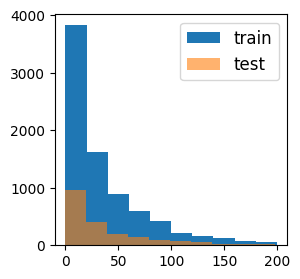

In [2]:
# prepare data
folder = 'nonlinear'
keywords = ['interaction', "latest", 'RW']
DATANAME = 'nl-interaction'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [36]:
kwargs = {
    'l1_ratio': 0.9, 
    'alphas':[0.1],
    'max_iter': 100000
    }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results
coxnet.write(coxnet_results)

N=50 Training time (0.0s): Train C-Index: 0.849 | Test C-index: 0.571
N=500 Training time (0.0s): Train C-Index: 0.628 | Test C-index: 0.584
N=1000 Training time (0.01s): Train C-Index: 0.622 | Test C-index: 0.595
N=2000 Training time (0.02s): Train C-Index: 0.619 | Test C-index: 0.599
N=5000 Training time (0.06s): Train C-Index: 0.597 | Test C-index: 0.595
N=8000 Training time (0.13s): Train C-Index: 0.598 | Test C-index: 0.595


### Nonlinear: Sine

Train event rate: 0.75175
Test event rate:  0.752
Survival time distribution:


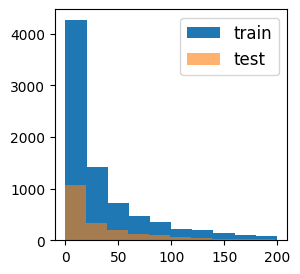

In [37]:
# prepare data
folder = 'nonlinear'
keywords = ['sine', "latest", 'RW']
DATANAME = 'nl-sine'
# train_df, val_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, val_split=True)
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)
X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

# observe data
print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
# ax.hist(val_df['time'],   label='val', alpha=.8)
ax.hist(test_df['time'], label='test', alpha=0.6)
ax.legend(fontsize=12)
plt.show()

In [38]:
kwargs = {
    'l1_ratio': 0.9, 
    'alphas':[0.1],
    'max_iter': 100000
    }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results
coxnet.write(coxnet_results)

N=50 Training time (0.0s): Train C-Index: 0.853 | Test C-index: 0.574
N=500 Training time (0.01s): Train C-Index: 0.677 | Test C-index: 0.578
N=1000 Training time (0.01s): Train C-Index: 0.633 | Test C-index: 0.585
N=2000 Training time (0.02s): Train C-Index: 0.617 | Test C-index: 0.595
N=5000 Training time (0.06s): Train C-Index: 0.598 | Test C-index: 0.592
N=8000 Training time (0.12s): Train C-Index: 0.6 | Test C-index: 0.595


In [ ]:
ds_results

,n train,train time,train score,test score
0,50,0.65,0.965414,0.581862
1,500,1.45,0.790279,0.598925
2,1000,2.48,0.690678,0.597732
3,2000,2.87,0.712586,0.626472
4,5000,3.65,0.672141,0.631717
5,8000,4.19,0.713149,0.659110


# Archive

In [ ]:
%%time
random_state = 42
subset = [50, 200, 500, 1000, 2000, 5000, 8000]
rsf_dict, rsf_train_scores, rsf_test_scores = {},{},{}

for n in subset:
    start = time.time() #record iteration start time
    
    # train the forest with subset of training set
    rsf = RandomSurvivalForest(
        n_estimators=500, 
        min_samples_split=10, 
        min_samples_leaf=15, 
        n_jobs=-1, random_state=random_state
    ).fit(X_train[:n], y_train[:n])

    stop = time.time() #Record time when training finished
    duration = round(stop - start, 2)
    
    train_sc = rsf.score(X_train[:n], y_train[:n])
    test_sc = rsf.score(X_test, y_test)
    print(f"N={n} Training time ({duration}s): Train C-Index: {round(train_sc,3)} | Test C-index: {round(test_sc,3)}")
    
    rsf_train_scores[str(n)] = train_sc
    rsf_test_scores[str(n)] = test_sc
    rsf_dict[str(n)] = rsf
    
#### OLD Scores
# 0.7567028514257128
# 0.8131055527763882
# 0.8276813406703352
# 0.8504412206103051
# 0.8567188594297148

N=50 Training time (1.67s): Train C-Index: 0.8179591836734694 | Test C-index: 0.6269144572286143
N=200 Training time (1.38s): Train C-Index: 0.8337688442211055 | Test C-index: 0.7161860930465233
N=500 Training time (5.23s): Train C-Index: 0.8278396793587174 | Test C-index: 0.7333466733366684
N=1000 Training time (24.26s): Train C-Index: 0.8331131131131131 | Test C-index: 0.7506423211605803
N=2000 Training time (119.71s): Train C-Index: 0.8352256128064032 | Test C-index: 0.7543821910955478
N=5000 Training time (848.3s): Train C-Index: 0.8323171034206841 | Test C-index: 0.7683871935967984
N=8000 Training time (2315.39s): Train C-Index: 0.8329373984248031 | Test C-index: 0.7732251125562781
CPU times: user 7h 33min 37s, sys: 6min 30s, total: 7h 40min 7s
Wall time: 58min 2s
